In [1]:
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.max_columns = 20
pd.options.display.max_rows = 500
from statistics import stdev, mean
import warnings
warnings.filterwarnings("ignore")
import math

# t- distribution Confidence Interval

In [2]:
def t_ci(confidence_interval: float = 0.90,
            sample_std_dev: float = 1,
            number_of_samples:int = 2,
            mean: float = 0,
            two_sided: bool = True
            ):
    '''
    

    Parameters
    ----------
    confidence_interval : float, optional
        DESCRIPTION. The default is 0.90.
    sample_std_dev : float, optional
        DESCRIPTION. The default is 1.
    number_of_samples : int, optional
        DESCRIPTION. The default is 100.
    mean : float, optional
        DESCRIPTION. The default is 0.
    two_sided : bool, optional
        DESCRIPTION. The default is True.

    Returns
    -------
    TYPE
        DESCRIPTION.

    '''
    # declaring problem constants
    x_bar = mean
    n = number_of_samples # number of samples taken
    sigma = sample_std_dev # population standard deviation
    sigma_x_bar = sigma/n**0.5 # std dev of sample means
    df = n-1 # degrees of freedom
    
    # generate x within 3.5 standard deviations and y axes
    x_axis_lower_bound = x_bar-3.5*sigma_x_bar
    x_axis_upper_bound = x_bar+3.5*sigma_x_bar
    steps = (x_axis_upper_bound-x_axis_lower_bound)/1000
    x = np.arange(x_axis_lower_bound,x_axis_upper_bound,steps)
    y = t.pdf(x,df, loc=x_bar,scale=sigma_x_bar)
    
    # get the probabilities of the tail areas
    if two_sided:
        alpha_high = (1+confidence_interval)/2
        alpha_low = (1-confidence_interval)/2
    else:
        alpha_high = confidence_interval
        alpha_low = 0
    # compute the value of x_lower and x_higher
    x_lower = t.ppf(alpha_low,df,loc=x_bar,scale=sigma_x_bar)
    x_higher = t.ppf(alpha_high,df,loc=x_bar,scale=sigma_x_bar)
    return round(x_lower,3), round(x_higher,3)

# Read the dataset

In [3]:
df = pd.read_csv(r'SA1_Group_17.csv', index_col='Index')

# Get the numerical and non-numerical columns
A separate dataset has been prepared to list out the numerical and the categorical columns.

In [4]:
column_desc = pd.read_csv(r'Data description.csv')
categorical_cols = column_desc.non_numeric_columns.dropna().tolist()
numeric_cols = column_desc.numeric_columns.dropna().tolist()

# View the dataset descriptive statistics of the numerical columns
Some Important points
 - Though OPER_DUR_DD is expected to be a continuous variable it looks like the rows are missing various data eventhough unit was operational. It just don't make sense that OPER_DUR_MM is filled (meaning the unit was operational for given number of months) but don't have the data OPER_DUR_DD (duration of operation in days). So for the descriptive statistics we will omit this as of now.
 - Other columns which are dropped because they are categorical in nature but were encoded. Getting descriptive statistics for categorical columns doesn't make sense. We will get distinct counts of them later.

In [5]:
print('Descriptive Statistics for the numerical columns')
display(df[numeric_cols].describe())

Descriptive Statistics for the numerical columns


,OPER_DUR_MM,MKT_VAL_FA,ORI_PURC_VAL_PM,EMP_TOTAL,GOP_Year3,VOE_Year3,NET_Year3
count,10000.000000,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04
mean,10.559000,8.547566e+05,3.245659e+05,5.885900,9.259034e+07,2.855352e+04,1.200584e+06
std,2.111437,5.466470e+06,1.791879e+06,10.858502,9.081048e+09,1.225493e+06,8.056149e+06
min,0.000000,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000e+00,-3.500000e+06
25%,10.000000,5.000000e+04,2.000000e+04,2.000000,4.666250e+04,0.000000e+00,5.700000e+04
50%,12.000000,1.500000e+05,5.045000e+04,3.000000,1.000000e+05,0.000000e+00,1.590000e+05
75%,12.000000,5.000000e+05,1.900000e+05,6.000000,3.800000e+05,0.000000e+00,5.112225e+05
max,12.000000,3.653958e+08,8.961474e+07,350.000000,9.081050e+11,9.430860e+07,4.269214e+08


<b>Inference:</b>Two majorly important columns GOP_Year3 and VOE_Year3 contains outliers. This is evident from their difference between mean and median. Let's try to remove the data which is the outlier.

# A quick view about the two columns containing outliers
Below we plot a scatter plot to visualize the presence of outliers in both the columns

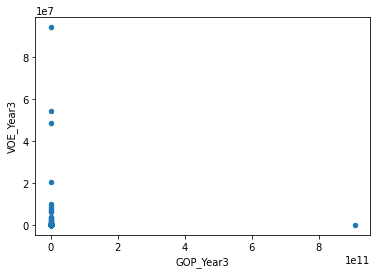

In [6]:
df.plot.scatter('GOP_Year3','VOE_Year3')

<b>Inference:</b>The single point on GOP_Year3 might going to be messing up with the whole statistical analysis. Let's remove them from the dataset

# Find out the data which is an outlier

In [7]:
def check_outlier(value,mean,sd):
    z = abs((value-mean)/sd)
    return z > 3.5
mean = df.GOP_Year3.mean()
sd = df.GOP_Year3.std()
df['GOP_Year3_is_outlier'] = df.GOP_Year3.apply(lambda row: check_outlier(row,mean,sd))

mean = df.VOE_Year3.mean()
sd = df.VOE_Year3.std()
df['VOE_Year3_is_outlier'] = df.VOE_Year3.apply(lambda row: check_outlier(row,mean,sd))
print('Number of outliers for GOP_Year3 outlier: {}'.format(len(df[df.GOP_Year3_is_outlier])))
print('Number of outliers for VOE_Year3 outlier: {}'.format(len(df[df.VOE_Year3_is_outlier])))

Number of outliers for GOP_Year3 outlier: 1
Number of outliers for VOE_Year3 outlier: 9


In [8]:
df_without_outliers = df[df.GOP_Year3_is_outlier==False]
df_without_outliers.GOP_Year3.describe()

count    9.999000e+03
mean     1.780014e+06
std      1.715855e+07
min      0.000000e+00
25%      4.662500e+04
50%      1.000000e+05
75%      3.800000e+05
max      1.193961e+09
Name: GOP_Year3, dtype: float64

<b>Inference:</b> As expected from the graph above 1 data point is an outlier in GOP_Year3. We shall elliminate that. But there are 9 data points as outliers for VOE_Year3. Losing out 9 more data can be problematic. We shall keep them and move forward.

# Question 1. The 95 percent confidence interval for the “Gross output – Year 3 (Rs)
To perform this we will construct a 2 sided 95% confidence interval by t-test

In [9]:
confidence_interval = 0.95
sample_std_dev = df_without_outliers.GOP_Year3.std()
number_of_samples = len(df_without_outliers.GOP_Year3)
sample_mean = df_without_outliers.GOP_Year3.mean()
lower, higher = t_ci(confidence_interval,sample_std_dev,number_of_samples,sample_mean)
print('Mean of Gross output – Year 3 of population is expected to lie between Rs. {} and Rs. {}'.format(lower,higher))

Mean of Gross output – Year 3 of population is expected to lie between Rs. 1443654.578 and Rs. 2116372.612


# <a id='metrics_definition'></a>Question 2: Defining metrics for performance of the units
We define the performance of the units as follows:<br>
1. <b>op_per_asset = GOP_Year3/MKT_VAL_FA.</b><br>
This metric is useful in determining how the units are performing on the basis of utilization of the fixed assets. As a basic understanding more the MKT_VAL_FA more should be GOP_Year3. If the ratio is low for any unit it means there might be a problem of under utilization of resources happening in that given unit. Also if the ratio is too high denotes the units are working with highly deprecated assets which can be a great risk sooner or later.


2. <b>op_per_employee: GOP_Year3/EMP_TOTAL</b><br>
In these world of automation initiatives to increase productivitiy of business this metric is very useful. If the ratio is too low it means those units might potentially show redundancies in job roles. Employees of those units might be available to take up newer challenging roles which in turn will be increasing the business. Units showing too high value might be facing employee shortage problems.

In [10]:
df_without_outliers['op_per_asset'] = df_without_outliers['GOP_Year3']/df_without_outliers['MKT_VAL_FA']
df_without_outliers['op_per_employee'] = df_without_outliers['GOP_Year3']/df_without_outliers['EMP_TOTAL']
print('Description of the two metrics')
display(df_without_outliers[['op_per_asset','op_per_employee']].describe())

Description of the two metrics


,op_per_asset,op_per_employee
count,9997.000000,9.999000e+03
mean,inf,1.479189e+05
std,NaN,9.660946e+05
min,0.000000,0.000000e+00
25%,0.450000,1.760000e+04
50%,0.900000,3.421429e+04
75%,1.790667,7.575000e+04
max,inf,7.595800e+07


<b>Inference:</b>It seems there are some rows in the data where the MKT_VAL_FA = 0 due to which we are getting inf values. This seems to be some sort of a data collection issue. To avoid this we filter the data to remove the inf values. Also there seems to be some missing values too. <a id='outlier1'></a>

In [11]:
import math
filtered_df = df_without_outliers[~df_without_outliers.op_per_asset.isna()]
filtered_df = df_without_outliers[df_without_outliers.op_per_asset != math.inf]
filtered_df[['op_per_asset','op_per_employee']].describe()

,op_per_asset,op_per_employee
count,9952.000000,9.954000e+03
mean,2.395023,1.476742e+05
std,12.030814,9.679534e+05
min,0.000000,0.000000e+00
25%,0.450000,1.750075e+04
50%,0.891083,3.406559e+04
75%,1.762542,7.526600e+04
max,601.500000,7.595800e+07


<b>Inference:</b> This resulted in losing out around 40 data points from our sample. There can be a separate analysis how those 40 data points had MKT_VAL_FA = 0. But this is out of scope for this exercise.

# Question 3: 99% confidence interval for the population mean of the above metrics

## 99% confidence interval for op_per_asset:
Since we have described that both low op_per_asset and high op_per_asset is a problem [here](#metrics_definition), we will define two sided confidence interval for the given metric

In [ ]:
confidence_interval = 0.99
sample_std_dev = filtered_df.op_per_asset.std()
number_of_samples = len(filtered_df.op_per_asset)
sample_mean = filtered_df.op_per_asset.mean()
two_sided = True
lower, higher = t_ci(confidence_interval,
                     sample_std_dev,
                     number_of_samples,
                     sample_mean,
                     two_sided
                    )
print('Mean of Output Per Asset as of Year 3 of population is expected to lie between {} and {}'.format(lower,higher))

## 99% confidence interval for op_per_employee:
Since we have described that both low op_per_employee and high op_per_asset is a problem [here](#metrics_definition), we will define two sided confidence interval for the given metric

In [ ]:
confidence_interval = 0.99
sample_std_dev = filtered_df.op_per_employee.std()
number_of_samples = len(filtered_df.op_per_employee)
sample_mean = filtered_df.op_per_employee.mean()
two_sided = True
lower, higher = t_ci(confidence_interval,
                     sample_std_dev,
                     number_of_samples,
                     sample_mean,
                     two_sided
                    )
print('Mean of Gross Output Per Employee as of Year 3 of population is expected to lie between Rs.{} and Rs.{}'.format(lower,higher))

# Question 4

## a. Probability that a firm selected at random is a SSSBE unit

In [ ]:
# filter only SSSBE units
p = len(filtered_df[filtered_df.UNIT_TYPE==2])/len(filtered_df)
print(f'Probability = {round(p,3)}')

## b. Probability that a firm selected at random is GOOD in performance
We calculate this by checking if the values of the column op_per_asset > mean of the column op_per_asset

In [ ]:
mean_op_per_asset = filtered_df.op_per_asset.mean()
filtered_df['good_in_performance'] = filtered_df.op_per_asset.apply(lambda row: row > mean_op_per_asset)
p = len(filtered_df[filtered_df.good_in_performance==True])/len(filtered_df)
print(f'Probability = {round(p,10)}')
print('Number of units performing good = {}'.format(len(filtered_df[filtered_df.good_in_performance==True])))

## c. Probability that a firm selected is a SSSBE Unit and ALSO GOOD in performance

In [ ]:
n_sssbe_good_performance = len(filtered_df[(filtered_df.UNIT_TYPE==2) \
                                            &(filtered_df.good_in_performance==True) \
                                       ])
print('Probability that firm is SSSBE Unit and also a good performer = {0:.3f}'.format(n_sssbe_good_performance/len(filtered_df)))
p_good_given_sssbe = n_sssbe_good_performance/len(filtered_df[(filtered_df.UNIT_TYPE==2)])
print('Conditional probability that a firm is Good given that its SSSBE:{}'.format(p_good_given_sssbe))

## d. Conclusion about performance of SSSBE units
From calculation in 4c. we can see that only a mere 3.5% of our sample data comprise of performances from SSSBE units which are performing good. But to conclude whether SSSBE units performance are good or bad in compared to SSI we have to do a comparative study.

In [ ]:
n_ssi_good_performance = len(filtered_df[(filtered_df.UNIT_TYPE==1) \
                                            &(filtered_df.good_in_performance==True) \
                                       ])
print('Probability that firm is SSI Unit and also a good performer = {0:.3f}'.format(n_ssi_good_performance/len(filtered_df)))
p_good_given_ssi = n_ssi_good_performance/len(filtered_df[(filtered_df.UNIT_TYPE==1)])
print('Conditional probability that a firm is Good given that its SSI:{}'.format(p_good_given_ssi))

<b>Inference: </b>From the above calculations it is clear that:
1. A majority of good performer is SSI units and not SSSBE units in our sample.
1. If we see the conditional probability to understand if given that a firm is an SSSBE unit what is the probability that it will perform good < if given that a firm is SSI Unit what is the probability of being good performer.

Based on these above caclculations it is evident that performance of SSSBE unit is not good as compared to SSI Units.

# 5. Null Hypothesis test
Null hypothesis H<sub>0</sub>: Population mean of VOE_Year3 = 87,300 <br>
Alternate Hypothesis H<sub>1</sub>: Population mean of VOE_Year3 ≠ 87,300 <br>
We will setup a one sided confidence interval of 0.95 <br>
Since population standard deviation is not given to us we will use sample standard deviation and use t test

In [ ]:
df_without_outliers.VOE_Year3.describe()

In [ ]:
confidence_interval = 0.95
sample_std_dev = df_without_outliers.VOE_Year3.std()
number_of_samples = len(df_without_outliers.VOE_Year3)
mean = 87300
two_sided = False
lower, higher = t_ci(confidence_interval,sample_std_dev,number_of_samples,mean,two_sided)
sample_mean = df_without_outliers.VOE_Year3.mean()
print('Sample Mean for Value of Exports for Year 3 is expected to lie between Rs. {} and Rs. {}'.format(lower,higher))
print(f'Does sample mean falls within above range? Ans: {lower<=sample_mean<=higher} and the value {sample_mean}')
print(f'The t value for sample mean:{t.cdf(sample_mean,df=number_of_samples-1,loc=mean,scale=sample_std_dev/number_of_samples**0.5)}')

<b>Inference:</b> It is evident that from the one sided t-test though the sample mean lies between the given ranges the P value is << 0.05. Hence we can surely reject the Null hypothesis that the population mean of VOE_Year3 is 87300.

# 6. Special incentives for SSSBE or SSI or both
<b>Explanation:</b> Below we will define the success criteria as follows:
1. If unit is an SSSBE Unit its a success. We calculate the population proportion of its success rate.
1. If unit is an SSI Unit its a success. We calculate the population proportion of its success rate.

For the unit to get incentives the population proportion of it should be < 0.25

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint

In [ ]:
confidence_interval = 0.99
sssbe_count = len(filtered_df[filtered_df.UNIT_TYPE==2])
total_count = len(filtered_df)


sssbe_pop_prop = proportion_confint(count=sssbe_count,    # Number of "successes"
                                   nobs=total_count,    # Number of trials
                                   alpha=(1 - confidence_interval))
print('Population proportion of SSSBE units is expected to lie within {} by confidence interval of {}'.format(sssbe_pop_prop, confidence_interval))

In [ ]:
confidence_interval = 0.99
sssbe_count = len(filtered_df[filtered_df.UNIT_TYPE==1])
total_count = len(filtered_df)

sssbe_pop_prop = proportion_confint(count=sssbe_count,    # Number of "successes"
                                   nobs=total_count,    # Number of trials
                                   alpha=(1 - confidence_interval))
print('Population proportion of SSI units is expected to lie within {} by confidence interval of {}'.format(sssbe_pop_prop, confidence_interval))

<b>Inference:</b> Since SSSBE Unit's population proportion is expected to be lying below 25% we would recommend these special incentives for SSSBE.

# 7. Contention that a larger proportion of SSSBEs are managed by men as compared to women
<b>Explanation:</b> For this we will estimate population proportion of SSSBE Units managed by Male. The column MAN_BY will be beneficial for this case.
1. We define success if a unit is managed by man.
1. We estimate the population proportion of SSSBE units to be managed by men from our sample by a set confidence interval.
1. If the estimated population proportion > 0.5 this contention will hold true.

In [ ]:
# filter out only SSSBE Units
sssbe_df = df[df.UNIT_TYPE == 2]
sssbe_df.MAN_BY.value_counts()

In [ ]:
confidence_interval = 0.99
no_of_sssbe_units_managed_by_men = len(sssbe_df[sssbe_df.MAN_BY == 1])
number_of_sssbe_units = len(sssbe_df)
male_employee_pop_prop = proportion_confint(count=no_of_sssbe_units_managed_by_men,    # Number of "successes"
                                           nobs=number_of_sssbe_units,    # Number of trials
                                           alpha=(1 - confidence_interval))
print('Population proportion of SSSBE units being managed by men is expected to lie within {} by confidence interval of {}'.format(sssbe_pop_prop, confidence_interval))

<b>Inference:</b> Thus we are 99% confident that the population proportion of SSSBE Units being managed by men lies much above 50%. Hence we are accepting the above contention.

# 8. Distribution of defined metrics <a id='normal_check'>

In [ ]:
filtered_df[['op_per_asset','op_per_employee']].describe()

In [ ]:
filtered_df['op_per_asset'].plot.hist(bins=35)

In [ ]:
filtered_df['op_per_employee'].plot.hist(bins=35)

<b>Inference:</b> The distributions of the metrics 'op_per_asset' and 'op_per_employee' are right skewed in nature. We can find the evidence from the above histograms and also the .describe() method [here](#normal_check) where it is seen that median << mean